In [162]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
from __future__ import division, print_function, absolute_import

In [164]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

# Using the Model to Make Predictions 

First, let's locate the latest model: It's called ```saved_model.pb```.

In [165]:
from temp_dir import temp_dir
import os
model_dir = os.path.join(temp_dir, "models/export/exporter")
versions = !ls $model_dir
print( "Versions: %s" % versions)
latest_version = max(versions)
latest_model = os.path.join(model_dir, str(latest_version))
!echo $latest_model
!ls $latest_model

Versions: ['1556975103', '1556975105', '1556975141']
/tmp/tmpxhfk07ff/models/export/exporter/1556975141
saved_model.pb	variables


Create an estimator from that model:

In [166]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from /tmp/tmpxhfk07ff/models/export/exporter/1556975141/variables/variables


Use it to predict the humidity for a single record:

In [167]:
sample = {
    'beta1': [[1.234],[1.234]],
    'beta2': [[1.234],[1.234]],
    'weekday': [[5], [6]],
    'hour': [[16], [17]]
}

In [168]:
estimator(sample)

{'output': array([[27.474072],
        [20.74772 ]], dtype=float32)}

### Verifying prediction quality against the test set

In [179]:
!ls $temp_dir

eval.tfr-00000-of-00001  signature_eval.csv   tftransform_tmp
metadata		 signature_test.csv   training.csv-00000-of-00001
models			 signature_train.csv  training.tfr-00000-of-00001


In [180]:
test_data = pd.read_csv(os.path.join(temp_dir, "signature_test.csv"))
test_data.head()

,beta1,beta2,hour,humidity,weekday
0,0.831619,-3.061597,11,24.322372,3
1,1.532263,0.100582,23,20.005085,6
2,-0.896022,3.209286,18,22.785082,1
3,-0.051112,3.814629,7,16.876502,4
4,0.674664,2.271453,4,18.432830,4


In [181]:
test_dict = test_data.drop('humidity', axis=1).to_dict(orient='list')
test_dict = { key: np.reshape(item, [-1,1]) for key, item in td.items()}

In [182]:
predicted = estimator(td)
len(predicted['output'])

20000

In [183]:
test_data['predicted'] = predicted['output'].reshape(-1)

In [184]:
test_data.head()

,beta1,beta2,hour,humidity,weekday,predicted
0,0.831619,-3.061597,11,24.322372,3,21.410419
1,1.532263,0.100582,23,20.005085,6,21.547585
2,-0.896022,3.209286,18,22.785082,1,22.788534
3,-0.051112,3.814629,7,16.876502,4,16.851084
4,0.674664,2.271453,4,18.432830,4,18.596155


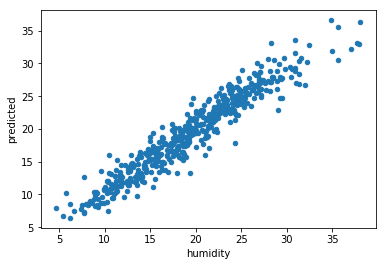

In [185]:
%matplotlib inline
test_data[:500].plot.scatter(x='humidity', y='predicted');

Our prediction strongly correlates with the measured humidity.

In [186]:
test_data['diff'] = test_data['humidity'] - test_data['predicted']

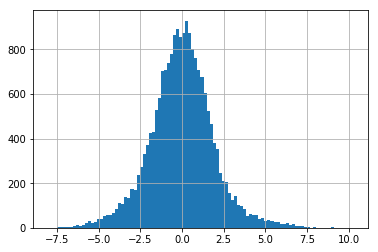

In [187]:
test_data['diff'].hist(bins=100);

And also, the error distribution is truly convincing. The remaining error is almost perfectly Gaussian.

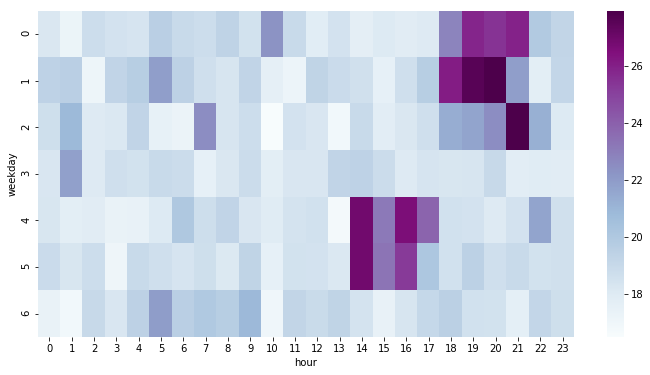

In [193]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
sns.heatmap(test_data.pivot_table(
    index='weekday', columns='hour', 
    values='predicted', aggfunc='mean'), cmap='BuPu');

The heatmap of predictions, averaged over $\beta_1$ and $\beta_2$ clearly shows that the model has figured out the anomaly that can be observed Mon-Wed between 18:00 and 21:00 and Fri-Sat between 14:00 and 16:00 hours.